In [1]:
pip install "protobuf==3.20.3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # tắt warning tokenizers trong dataloader workers

import random, time, warnings
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPProcessor, CLIPModel, get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")


2025-12-13 15:14:34.031464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765638874.225193      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765638874.278683      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
@dataclass
class Config:
    data_dir: str = "/kaggle/input/fashion-product-text-images-dataset/data"
    csv_path: str = "/kaggle/input/fashion-product-text-images-dataset/data.csv"
    clip_model_name: str = "openai/clip-vit-base-patch32"
    clip_max_text_len: int = 77

    # data
    batch_size: int = 64
    num_workers: int = 2

    # effective batch
    grad_accum_steps: int = 2  # effective batch = batch_size * grad_accum_steps

    # finetune
    lr: float = 1e-5
    weight_decay: float = 0.01
    num_epochs: int = 65
    patience: int = 23
    grad_clip_norm: float = 1.0

    # unfreeze control (partial finetune)
    unfreeze_text_last_n: int = 4
    unfreeze_vision_last_n: int = 4

    # scheduler
    warmup_ratio: float = 0.05

    # loss blending
    supcon_weight: float = 0.15
    supcon_temp: float = 0.07
    ignore_category: str = "Other"  # do not use "Other" as supervised positives

    # rare category merge for stratify
    min_samples_per_cat: int = 5

    # evaluation subset for quick monitor
    monitor_subset: int = 5000

    # tsne
    tsne_top_k: int = 10
    tsne_points_per_cat: int = 250  # tổng điểm ~ top_k * points_per_cat
    tsne_perplexity: int = 40
    tsne_iter: int = 1500

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42
    amp: bool = True

config = Config()

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(config.seed)
print("Device:", config.device)
print("Effective batch:", config.batch_size * config.grad_accum_steps)


Device: cuda
Effective batch: 128


Shape: (44441, 5)
image           0
description     0
display_name    0
category        0
dtype: int64


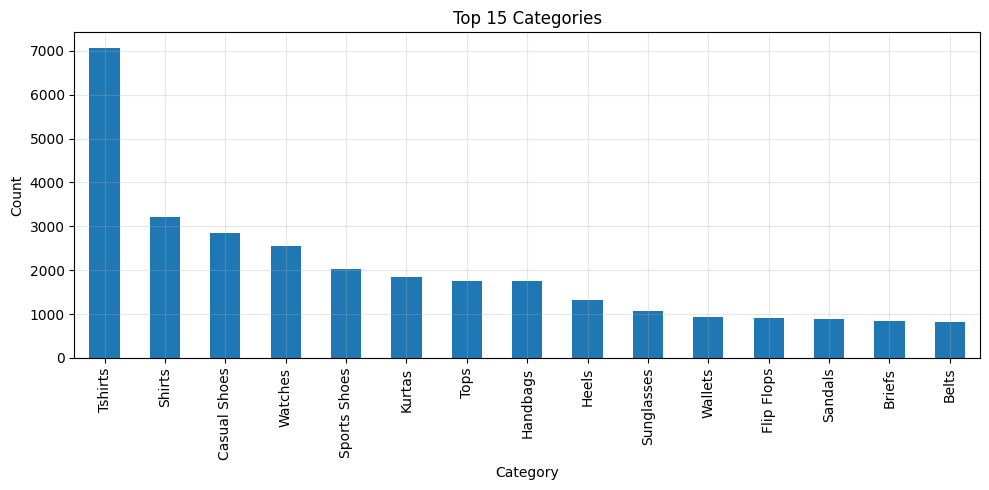

In [4]:
df = pd.read_csv(config.csv_path)
df.columns = df.columns.str.strip().str.replace(" ", "_")

required_cols = ["image", "description", "display_name", "category"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df["description"] = df["description"].fillna("")
df["display_name"] = df["display_name"].fillna("")
df["category"] = df["category"].fillna("Unknown")

def build_text(row):
    cat = str(row["category"])
    name = str(row["display_name"]).strip()
    desc = str(row["description"]).strip()
    desc_short = desc[:240]
    text = f"Category: {cat}. Name: {name}. Description: {desc_short}"
    return text.strip()

df["text"] = df.apply(build_text, axis=1)

print("Shape:", df.shape)
print(df[required_cols].isna().sum())

# EDA category
top_cats = df["category"].value_counts().head(15)
plt.figure(figsize=(10,5))
top_cats.plot(kind="bar")
plt.title("Top 15 Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Tokenizing for stats:   0%|          | 0/5000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (78 > 77). Running this sequence through the model will result in indexing errors


Token length mean: 62.9012
p90: 74.0 p95: 77.0
% > 77 tokens: 3.6999999999999997


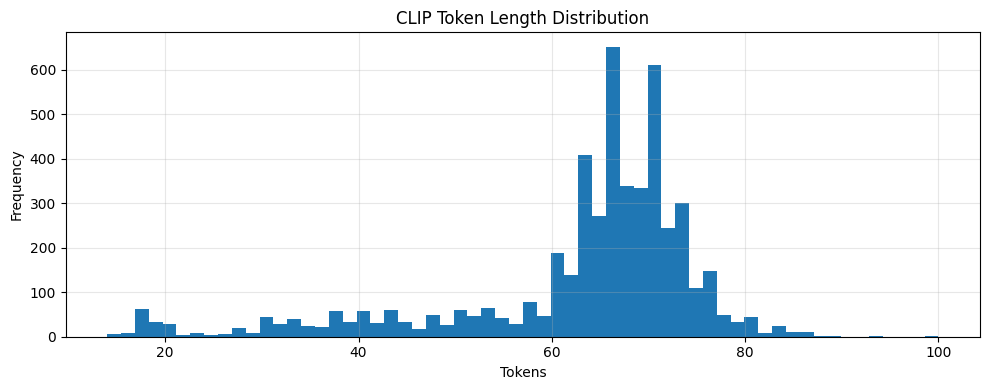

In [5]:
processor = CLIPProcessor.from_pretrained(config.clip_model_name)

sample_texts = df["text"].sample(min(5000, len(df)), random_state=config.seed).tolist()
tok_lens = []
for t in tqdm(sample_texts, desc="Tokenizing for stats"):
    enc = processor.tokenizer(t, truncation=False, padding=False, return_attention_mask=False)
    tok_lens.append(len(enc["input_ids"]))
tok_lens = np.array(tok_lens)

print("Token length mean:", tok_lens.mean())
print("p90:", np.percentile(tok_lens, 90), "p95:", np.percentile(tok_lens, 95))
print("% > 77 tokens:", (tok_lens > config.clip_max_text_len).mean() * 100)

plt.figure(figsize=(10,4))
plt.hist(tok_lens, bins=60)
plt.title("CLIP Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
cat_counts = df["category"].value_counts()
rare = cat_counts[cat_counts < config.min_samples_per_cat].index
df_fixed = df.copy()
df_fixed.loc[df_fixed["category"].isin(rare), "category"] = config.ignore_category

print("Rare categories merged:", len(rare))
print("Min count after merge:", df_fixed["category"].value_counts().min())

def safe_two_stage_stratified_split(df_in, seed=42):
    train_df, temp_df = train_test_split(
        df_in, test_size=0.30, random_state=seed, stratify=df_in["category"]
    )
    temp_counts = temp_df["category"].value_counts()
    temp_rare = temp_counts[temp_counts < 2].index
    if len(temp_rare) > 0:
        temp_df = temp_df.copy()
        temp_df.loc[temp_df["category"].isin(temp_rare), "category"] = config.ignore_category

    val_df, test_df = train_test_split(
        temp_df, test_size=0.50, random_state=seed, stratify=temp_df["category"]
    )
    return train_df, val_df, test_df

train_df, val_df, test_df = safe_two_stage_stratified_split(df_fixed, seed=config.seed)
print("Train/Val/Test:", len(train_df), len(val_df), len(test_df))
print("Val min count:", val_df["category"].value_counts().min())
print("Test min count:", test_df["category"].value_counts().min())


Rare categories merged: 19
Min count after merge: 5
Train/Val/Test: 31108 6666 6667
Val min count: 1
Test min count: 1


In [7]:
class CLIPFashionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, data_dir: str, processor: CLIPProcessor, config: Config):
        self.df = df.reset_index(drop=True).copy()
        self.data_dir = data_dir
        self.processor = processor
        self.config = config

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_dir, row["image"])
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), color="white")

        text = row["text"]
        inputs = self.processor(
            text=text,
            images=image,
            padding="max_length",
            truncation=True,
            max_length=self.config.clip_max_text_len,
            return_tensors="pt"
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "category": row["category"],
        }

train_ds = CLIPFashionDataset(train_df, config.data_dir, processor, config)
val_ds   = CLIPFashionDataset(val_df,   config.data_dir, processor, config)
test_ds  = CLIPFashionDataset(test_df,  config.data_dir, processor, config)

train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True,
                          num_workers=config.num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False,
                          num_workers=config.num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False,
                          num_workers=config.num_workers, pin_memory=True)

print("Dataloaders ready.")


Dataloaders ready.


In [8]:
class CLIPTwoTower(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.clip = CLIPModel.from_pretrained(config.clip_model_name)

    def forward(self, pixel_values, input_ids, attention_mask):
        out = self.clip(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        img_emb = F.normalize(out.image_embeds, p=2, dim=-1)  # (B,512)
        txt_emb = F.normalize(out.text_embeds,  p=2, dim=-1)  # (B,512)
        return img_emb, txt_emb, self.clip.logit_scale

def freeze_all(model: nn.Module):
    for p in model.parameters():
        p.requires_grad = False

def unfreeze_last_n_clip_layers(model: CLIPModel, n_text: int, n_vision: int):
    freeze_all(model)
    model.logit_scale.requires_grad = True

    text_layers = model.text_model.encoder.layers
    for layer in text_layers[-n_text:]:
        for p in layer.parameters():
            p.requires_grad = True

    vision_layers = model.vision_model.encoder.layers
    for layer in vision_layers[-n_vision:]:
        for p in layer.parameters():
            p.requires_grad = True

    for p in model.text_model.final_layer_norm.parameters():
        p.requires_grad = True
    for p in model.vision_model.post_layernorm.parameters():
        p.requires_grad = True
    for p in model.visual_projection.parameters():
        p.requires_grad = True
    for p in model.text_projection.parameters():
        p.requires_grad = True

def build_param_groups(model: nn.Module, weight_decay: float):
    no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight", "ln_", "layernorm", "logit_scale"]
    decay_params, nodecay_params = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if any(nd in n for nd in no_decay):
            nodecay_params.append(p)
        else:
            decay_params.append(p)
    return [
        {"params": decay_params, "weight_decay": weight_decay},
        {"params": nodecay_params, "weight_decay": 0.0},
    ]

model = CLIPTwoTower(config).to(config.device)
unfreeze_last_n_clip_layers(model.clip, config.unfreeze_text_last_n, config.unfreeze_vision_last_n)

trainable = sum(p.requires_grad for p in model.parameters())
total = sum(1 for _ in model.parameters())
print(f"Trainable params tensors: {trainable}/{total}")


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Trainable params tensors: 135/398


In [9]:
class CLIPContrastiveLoss(nn.Module):
    def forward(self, img_emb, txt_emb, logit_scale):
        scale = logit_scale.exp()
        logits_i2t = scale * (img_emb @ txt_emb.t())
        logits_t2i = logits_i2t.t()
        labels = torch.arange(img_emb.size(0), device=img_emb.device)
        return 0.5 * (F.cross_entropy(logits_i2t, labels) + F.cross_entropy(logits_t2i, labels))

class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07, ignore_label="Other"):
        super().__init__()
        self.temperature = temperature
        self.ignore_label = ignore_label

    def forward(self, emb, labels):
        device = emb.device
        labels = np.array(labels)
        valid = labels != self.ignore_label
        if valid.sum() < 2:
            return emb.new_tensor(0.0)

        emb_v = emb[torch.tensor(valid, device=device)]
        lab_v = labels[valid]
        Nv = emb_v.size(0)

        sim = (emb_v @ emb_v.t()) / self.temperature
        sim = sim - torch.max(sim, dim=1, keepdim=True)[0]

        lab_v_t = torch.tensor(pd.factorize(lab_v)[0], device=device)
        pos_mask = (lab_v_t.unsqueeze(0) == lab_v_t.unsqueeze(1)).float()
        self_mask = torch.eye(Nv, device=device)
        pos_mask = pos_mask * (1.0 - self_mask)

        exp_sim = torch.exp(sim) * (1.0 - self_mask)
        log_prob = sim - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-12)

        pos_count = pos_mask.sum(dim=1)
        loss = -(pos_mask * log_prob).sum(dim=1) / (pos_count + 1e-12)
        loss = loss[pos_count > 0].mean() if (pos_count > 0).any() else emb.new_tensor(0.0)
        return loss

clip_loss_fn = CLIPContrastiveLoss()
supcon_loss_fn = SupervisedContrastiveLoss(temperature=config.supcon_temp, ignore_label=config.ignore_category)


In [10]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, config: Config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config

        param_groups = build_param_groups(self.model, config.weight_decay)
        self.optimizer = torch.optim.AdamW(param_groups, lr=config.lr)

        steps_per_epoch = max(1, len(train_loader) // config.grad_accum_steps)
        total_steps = max(1, steps_per_epoch * config.num_epochs)
        warmup_steps = int(config.warmup_ratio * total_steps)

        self.scheduler = get_cosine_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        self.scaler = torch.cuda.amp.GradScaler(enabled=(config.amp and config.device=="cuda"))

        self.best_val = float("inf")
        self.patience_counter = 0
        self.train_losses, self.val_losses = [], []
        self.monitor_recall10 = []

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0
        self.optimizer.zero_grad(set_to_none=True)

        pbar = tqdm(self.train_loader, desc="Training", leave=True)
        for step, batch in enumerate(pbar):
            pixel_values = batch["pixel_values"].to(self.config.device)
            input_ids = batch["input_ids"].to(self.config.device)
            attention_mask = batch["attention_mask"].to(self.config.device)
            cats = batch["category"]

            with torch.cuda.amp.autocast(enabled=(self.config.amp and self.config.device=="cuda")):
                img_emb, txt_emb, logit_scale = self.model(pixel_values, input_ids, attention_mask)
                loss_clip = clip_loss_fn(img_emb, txt_emb, logit_scale)

                item_emb = F.normalize((img_emb + txt_emb) / 2, p=2, dim=-1)
                loss_sup = supcon_loss_fn(item_emb, cats)

                loss = loss_clip + self.config.supcon_weight * loss_sup
                loss = loss / self.config.grad_accum_steps

            self.scaler.scale(loss).backward()

            if (step + 1) % self.config.grad_accum_steps == 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.grad_clip_norm)

                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)
                self.scheduler.step()

            total_loss += loss.item() * self.config.grad_accum_steps

            if step % 20 == 0:
                lr_now = self.optimizer.param_groups[0]["lr"]
                pbar.set_postfix_str(
                    f"loss={total_loss/(step+1):.4f} | lr={lr_now:.2e} | scale={logit_scale.exp().item():.1f}"
                )

        return total_loss / len(self.train_loader)

    @torch.no_grad()
    def validate_loss(self):
        self.model.eval()
        total = 0.0
        for batch in tqdm(self.val_loader, desc="Validation", leave=False):
            pixel_values = batch["pixel_values"].to(self.config.device)
            input_ids = batch["input_ids"].to(self.config.device)
            attention_mask = batch["attention_mask"].to(self.config.device)
            cats = batch["category"]

            img_emb, txt_emb, logit_scale = self.model(pixel_values, input_ids, attention_mask)
            loss_clip = clip_loss_fn(img_emb, txt_emb, logit_scale)
            item_emb = F.normalize((img_emb + txt_emb) / 2, p=2, dim=-1)
            loss_sup = supcon_loss_fn(item_emb, cats)
            loss = loss_clip + self.config.supcon_weight * loss_sup

            total += loss.item()
        return total / len(self.val_loader)

    @torch.no_grad()
    def quick_recall10_monitor(self, loader, max_items=5000):
        self.model.eval()
        embs = []
        cats = []
        count = 0
        for batch in loader:
            pixel_values = batch["pixel_values"].to(self.config.device)
            input_ids = batch["input_ids"].to(self.config.device)
            attention_mask = batch["attention_mask"].to(self.config.device)

            img_emb, txt_emb, _ = self.model(pixel_values, input_ids, attention_mask)
            item_emb = F.normalize((img_emb + txt_emb) / 2, p=2, dim=-1)

            embs.append(item_emb.cpu().numpy())
            cats.extend(batch["category"])
            count += len(batch["category"])
            if count >= max_items:
                break

        embs = np.vstack(embs)
        cats = np.array(cats)

        sim = cosine_similarity(embs)
        np.fill_diagonal(sim, -np.inf)

        hit = 0
        for i in range(sim.shape[0]):
            topk = np.argsort(sim[i])[-10:][::-1]
            if np.any(cats[topk] == cats[i]):
                hit += 1
        return hit / sim.shape[0]

    def fit(self, save_path="CLIP_Finetune_best.pth"):
        start = time.time()
        for epoch in range(self.config.num_epochs):
            tr = self.train_epoch()
            va = self.validate_loss()
            self.train_losses.append(tr)
            self.val_losses.append(va)

            r10 = self.quick_recall10_monitor(self.val_loader, max_items=self.config.monitor_subset)
            self.monitor_recall10.append(r10)

            lr_now = self.optimizer.param_groups[0]["lr"]
            print(f"Epoch {epoch+1}/{self.config.num_epochs} | LR={lr_now:.2e} | Train {tr:.6f} | Val {va:.6f} | Monitor Recall@10 {r10:.4f}")

            if va < self.best_val:
                self.best_val = va
                self.patience_counter = 0
                torch.save(self.model.state_dict(), save_path)
                print("  Saved best checkpoint.")
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.config.patience:
                print("Early stopping.")
                break

        print("Training time (s):", round(time.time()-start, 1))
        return save_path

trainer = Trainer(model, train_loader, val_loader, config)


In [11]:
best_ckpt = trainer.fit(save_path="CLIP_Finetune_best.pth")
model.load_state_dict(torch.load(best_ckpt, map_location=config.device))
model.eval()
print("Loaded best:", best_ckpt)


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/65 | LR=3.08e-06 | Train 0.697919 | Val 0.573923 | Monitor Recall@10 0.9854
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/65 | LR=6.16e-06 | Train 0.508044 | Val 0.474296 | Monitor Recall@10 0.9917
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/65 | LR=9.24e-06 | Train 0.413159 | Val 0.430971 | Monitor Recall@10 0.9941
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/65 | LR=1.00e-05 | Train 0.359252 | Val 0.401561 | Monitor Recall@10 0.9945
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/65 | LR=9.98e-06 | Train 0.318728 | Val 0.387697 | Monitor Recall@10 0.9943
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/65 | LR=9.95e-06 | Train 0.296248 | Val 0.377500 | Monitor Recall@10 0.9947
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/65 | LR=9.91e-06 | Train 0.282088 | Val 0.369483 | Monitor Recall@10 0.9945
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/65 | LR=9.85e-06 | Train 0.266238 | Val 0.368858 | Monitor Recall@10 0.9945
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/65 | LR=9.79e-06 | Train 0.254818 | Val 0.364101 | Monitor Recall@10 0.9947
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/65 | LR=9.71e-06 | Train 0.248878 | Val 0.353811 | Monitor Recall@10 0.9953
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/65 | LR=9.62e-06 | Train 0.243033 | Val 0.352699 | Monitor Recall@10 0.9955
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/65 | LR=9.51e-06 | Train 0.238192 | Val 0.348130 | Monitor Recall@10 0.9956
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/65 | LR=9.40e-06 | Train 0.232763 | Val 0.348477 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/65 | LR=9.27e-06 | Train 0.226796 | Val 0.348434 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/65 | LR=9.13e-06 | Train 0.224634 | Val 0.344842 | Monitor Recall@10 0.9958
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/65 | LR=8.98e-06 | Train 0.221519 | Val 0.340110 | Monitor Recall@10 0.9958
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 17/65 | LR=8.83e-06 | Train 0.216890 | Val 0.339118 | Monitor Recall@10 0.9956
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 18/65 | LR=8.66e-06 | Train 0.215517 | Val 0.334394 | Monitor Recall@10 0.9958
  Saved best checkpoint.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 19/65 | LR=8.48e-06 | Train 0.212910 | Val 0.343723 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 20/65 | LR=8.29e-06 | Train 0.209090 | Val 0.345909 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 21/65 | LR=8.10e-06 | Train 0.207576 | Val 0.340452 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 22/65 | LR=7.89e-06 | Train 0.207859 | Val 0.338586 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 23/65 | LR=7.68e-06 | Train 0.206159 | Val 0.344977 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 24/65 | LR=7.46e-06 | Train 0.202322 | Val 0.337613 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 25/65 | LR=7.24e-06 | Train 0.202294 | Val 0.338324 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 26/65 | LR=7.01e-06 | Train 0.200493 | Val 0.339219 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 27/65 | LR=6.77e-06 | Train 0.199655 | Val 0.342640 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 28/65 | LR=6.53e-06 | Train 0.199306 | Val 0.335439 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 29/65 | LR=6.29e-06 | Train 0.197452 | Val 0.340303 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 30/65 | LR=6.04e-06 | Train 0.196300 | Val 0.340797 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 31/65 | LR=5.79e-06 | Train 0.194318 | Val 0.341512 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 32/65 | LR=5.54e-06 | Train 0.192177 | Val 0.341455 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 33/65 | LR=5.29e-06 | Train 0.192106 | Val 0.343013 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 34/65 | LR=5.03e-06 | Train 0.192883 | Val 0.343980 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 35/65 | LR=4.78e-06 | Train 0.190935 | Val 0.340085 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 36/65 | LR=4.52e-06 | Train 0.190911 | Val 0.339269 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 37/65 | LR=4.27e-06 | Train 0.188847 | Val 0.347385 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 38/65 | LR=4.02e-06 | Train 0.190329 | Val 0.349112 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 39/65 | LR=3.77e-06 | Train 0.188497 | Val 0.347322 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 40/65 | LR=3.53e-06 | Train 0.190490 | Val 0.351934 | Monitor Recall@10 0.9958


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 41/65 | LR=3.29e-06 | Train 0.186968 | Val 0.354370 | Monitor Recall@10 0.9958
Early stopping.
Training time (s): 28362.5
Loaded best: CLIP_Finetune_best.pth


In [12]:
def recall_at_k(sim, categories, k_list=[1,5,10]):
    cats = np.array(categories)
    n = sim.shape[0]
    results = {}
    for k in k_list:
        hit = 0
        for i in range(n):
            topk = np.argsort(sim[i])[-k:][::-1]
            if np.any(cats[topk] == cats[i]):
                hit += 1
        results[f"Recall@{k}"] = hit / n
    return results

def mrr(sim, categories):
    cats = np.array(categories)
    n = sim.shape[0]
    rr = []
    for i in range(n):
        order = np.argsort(sim[i])[::-1]
        found = 0.0
        for r, j in enumerate(order, start=1):
            if cats[j] == cats[i]:
                found = 1.0 / r
                break
        rr.append(found)
    return float(np.mean(rr))

def ndcg_at_k(sim, categories, k=10):
    cats = np.array(categories)
    n = sim.shape[0]
    scores = []
    for i in range(n):
        order = np.argsort(sim[i])[::-1][:k]
        rel = (cats[order] == cats[i]).astype(np.int32)
        dcg = 0.0
        for idx, r in enumerate(rel, start=1):
            dcg += r / np.log2(idx + 1)
        idcg = sum(1.0 / np.log2(idx + 1) for idx in range(1, k+1))
        scores.append(dcg / idcg if idcg > 0 else 0.0)
    return float(np.mean(scores))

@torch.no_grad()
def extract_item_embeddings(model, loader, device):
    model.eval()
    embs = []
    cats = []
    for batch in tqdm(loader, desc="Extract embeddings"):
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        img_emb, txt_emb, _ = model(pixel_values, input_ids, attention_mask)
        item_emb = F.normalize((img_emb + txt_emb) / 2, p=2, dim=-1)
        embs.append(item_emb.cpu().numpy())
        cats.extend(batch["category"])
    return np.vstack(embs), cats

test_embs, test_cats = extract_item_embeddings(model, test_loader, config.device)
sim = cosine_similarity(test_embs)
np.fill_diagonal(sim, -np.inf)

metrics = {}
metrics.update(recall_at_k(sim, test_cats, [1,5,10]))
metrics["MRR"] = mrr(sim, test_cats)
metrics["NDCG@10"] = ndcg_at_k(sim, test_cats, k=10)

print("Test metrics:", metrics)


Extract embeddings:   0%|          | 0/105 [00:00<?, ?it/s]

Test metrics: {'Recall@1': 0.9929503524823758, 'Recall@5': 0.9956502174891255, 'Recall@10': 0.9965501724913755, 'MRR': 0.9942613326229751, 'NDCG@10': 0.9799592331856093}


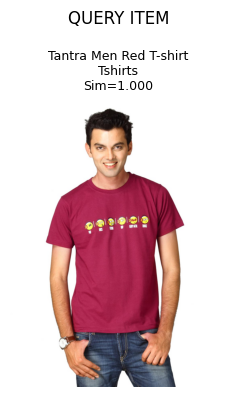

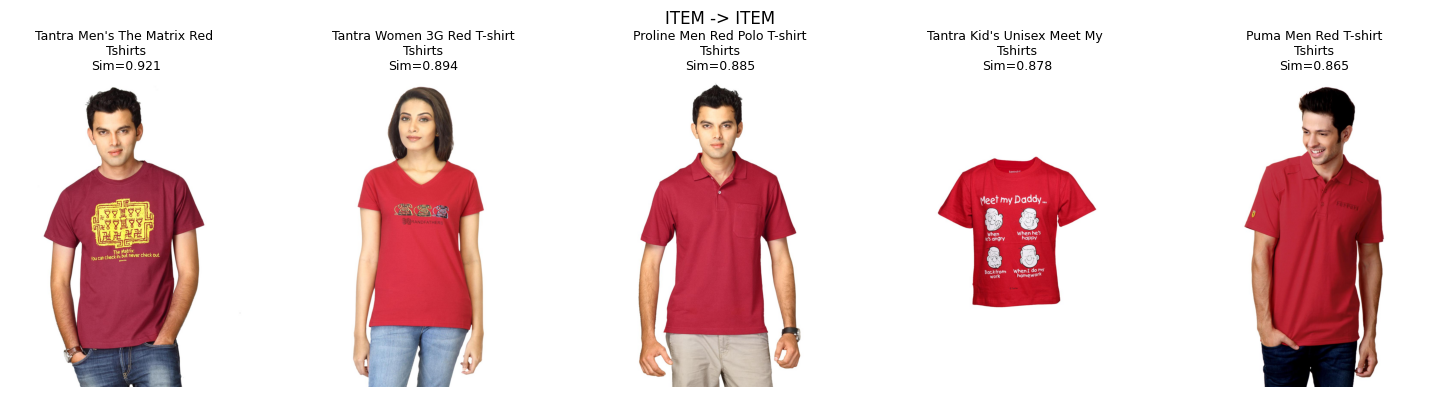

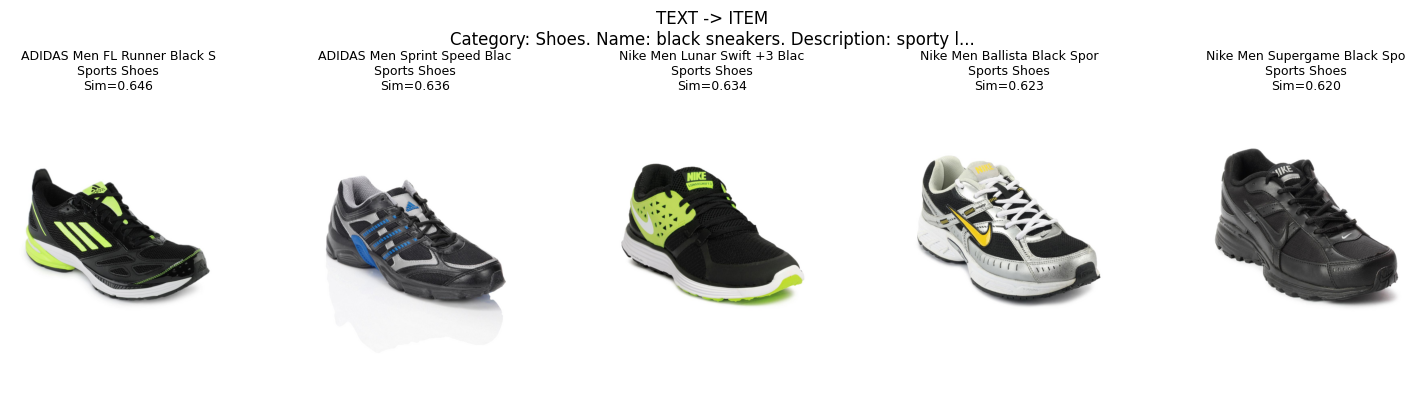

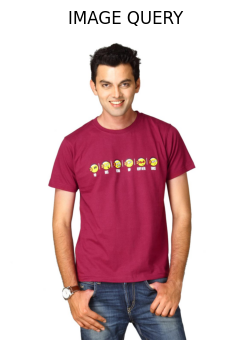

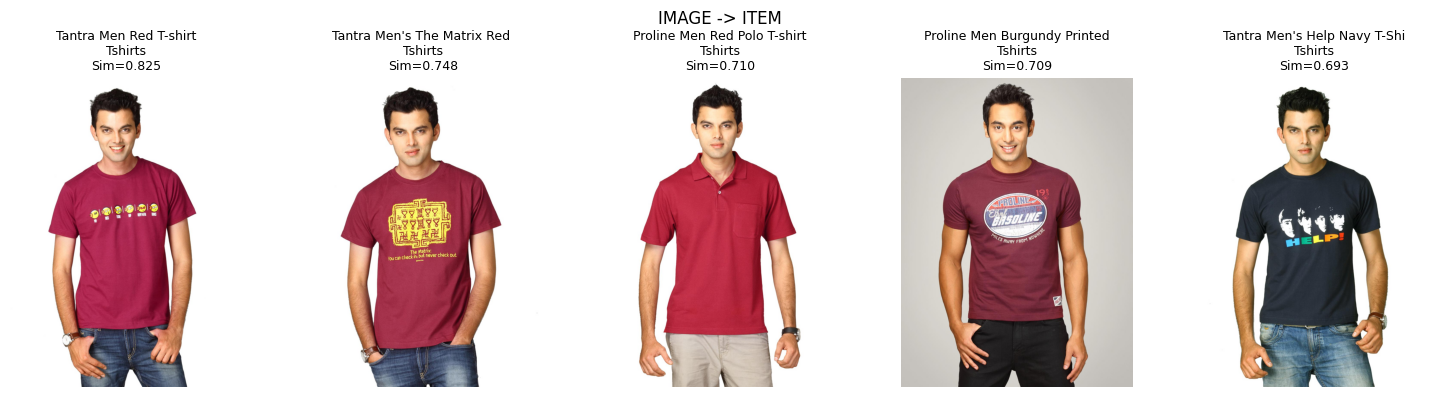

In [13]:
test_df_show = test_df.reset_index(drop=True).copy()

def show_items(indices, scores, df_ref, title):
    n = len(indices)
    plt.figure(figsize=(3*n, 4))
    for i, (idx, sc) in enumerate(zip(indices, scores)):
        plt.subplot(1, n, i+1)
        img_path = os.path.join(config.data_dir, df_ref.loc[idx, "image"])
        try:
            img = Image.open(img_path).convert("RGB")
            plt.imshow(img)
        except:
            plt.text(0.5, 0.5, "Image not found", ha="center", va="center")
        plt.axis("off")
        name = str(df_ref.loc[idx, "display_name"])[:28]
        cat = str(df_ref.loc[idx, "category"])
        plt.title(f"{name}\n{cat}\nSim={sc:.3f}", fontsize=9)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def recommend_by_item(query_idx, top_k=5):
    q = test_embs[query_idx].reshape(1, -1)
    sims = cosine_similarity(q, test_embs)[0]
    sims[query_idx] = -np.inf
    top = np.argsort(sims)[-top_k:][::-1]
    return top, sims[top]

@torch.no_grad()
def text_embedding(text: str):
    inputs = processor(text=text, images=None, return_tensors="pt",
                       padding=True, truncation=True, max_length=config.clip_max_text_len)
    inputs = {k: v.to(config.device) for k, v in inputs.items() if k in ["input_ids", "attention_mask"]}
    feat = model.clip.get_text_features(**inputs)
    return F.normalize(feat, p=2, dim=-1).cpu().numpy()[0]

def recommend_by_text(text: str, top_k=5):
    q = text_embedding(text).reshape(1, -1)
    sims = cosine_similarity(q, test_embs)[0]
    top = np.argsort(sims)[-top_k:][::-1]
    return top, sims[top]

@torch.no_grad()
def image_embedding(image_pil: Image.Image):
    inputs = processor(images=image_pil, text=None, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(config.device)
    feat = model.clip.get_image_features(pixel_values=pixel_values)
    return F.normalize(feat, p=2, dim=-1).cpu().numpy()[0]

def recommend_by_image(image_path: str, top_k=5):
    img = Image.open(image_path).convert("RGB")
    q = image_embedding(img).reshape(1, -1)
    sims = cosine_similarity(q, test_embs)[0]
    top = np.argsort(sims)[-top_k:][::-1]
    return img, top, sims[top]

# Demo
query_idx = 0
top, sc = recommend_by_item(query_idx, top_k=5)
show_items([query_idx], [1.0], test_df_show, "QUERY ITEM")
show_items(top, sc, test_df_show, "ITEM -> ITEM")

text_q = "Category: Shoes. Name: black sneakers. Description: sporty lightweight running shoes"
top2, sc2 = recommend_by_text(text_q, top_k=5)
show_items(top2, sc2, test_df_show, f"TEXT -> ITEM\n{text_q[:60]}...")

img_query_path = os.path.join(config.data_dir, test_df_show.loc[query_idx, "image"])
img, top3, sc3 = recommend_by_image(img_query_path, top_k=5)
plt.figure(figsize=(4,4)); plt.imshow(img); plt.axis("off"); plt.title("IMAGE QUERY"); plt.show()
show_items(top3, sc3, test_df_show, "IMAGE -> ITEM")


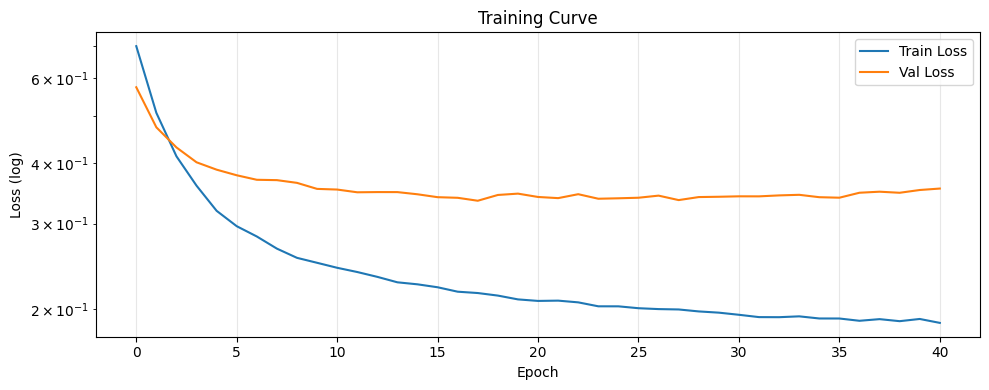

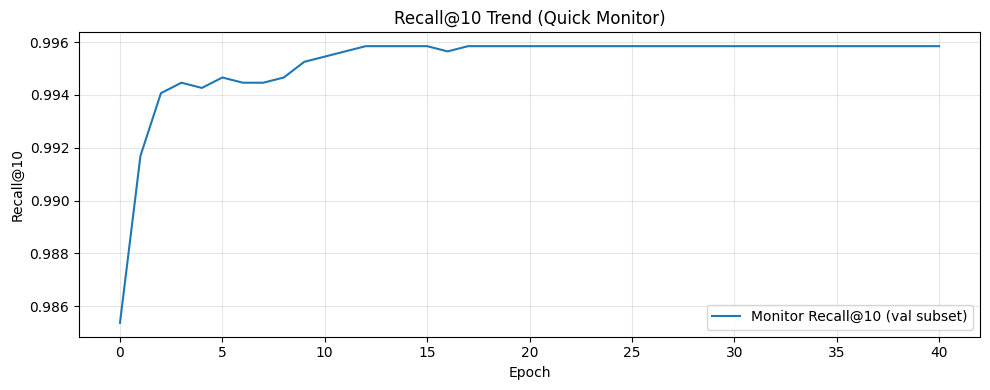

Saved: clip_training_curve.png, clip_recall10_trend.png


In [14]:
fig = plt.figure(figsize=(10,4))
plt.plot(trainer.train_losses, label="Train Loss")
plt.plot(trainer.val_losses, label="Val Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss (log)")
plt.title("Training Curve")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
fig.savefig("clip_training_curve.png", dpi=200, bbox_inches="tight")
plt.show()

fig2 = plt.figure(figsize=(10,4))
plt.plot(trainer.monitor_recall10, label="Monitor Recall@10 (val subset)")
plt.xlabel("Epoch")
plt.ylabel("Recall@10")
plt.title("Recall@10 Trend (Quick Monitor)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
fig2.savefig("clip_recall10_trend.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved: clip_training_curve.png, clip_recall10_trend.png")


In [15]:
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("clip_metrics.csv", index=False)

np.save("test_item_embeddings.npy", test_embs)
pd.Series(test_cats).to_csv("test_categories.csv", index=False)

with open("clip_run_summary.txt", "w", encoding="utf-8") as f:
    f.write("CLIP Finetune Multimodal Recommendation (Improved)\n")
    f.write(f"Model: {config.clip_model_name}\n")
    f.write(f"Train/Val/Test: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}\n")
    f.write(f"Batch size: {config.batch_size}\n")
    f.write(f"Grad accum: {config.grad_accum_steps}\n")
    f.write(f"Effective batch: {config.batch_size*config.grad_accum_steps}\n")
    f.write(f"LR: {config.lr}\n")
    f.write(f"Warmup ratio: {config.warmup_ratio}\n")
    f.write(f"Unfreeze text last N: {config.unfreeze_text_last_n}\n")
    f.write(f"Unfreeze vision last N: {config.unfreeze_vision_last_n}\n")
    f.write(f"SupCon weight: {config.supcon_weight}\n")
    f.write("Metrics:\n")
    for k, v in metrics.items():
        f.write(f"- {k}: {v}\n")

print("Saved: clip_metrics.csv, test_item_embeddings.npy, test_categories.csv, clip_run_summary.txt")
print("Best checkpoint:", best_ckpt)


Saved: clip_metrics.csv, test_item_embeddings.npy, test_categories.csv, clip_run_summary.txt
Best checkpoint: CLIP_Finetune_best.pth


t-SNE points: 2360 | dim: 512
Top10: ['Tshirts', 'Shirts', 'Casual Shoes', 'Watches', 'Sports Shoes', 'Kurtas', 'Tops', 'Handbags', 'Heels', 'Sunglasses']


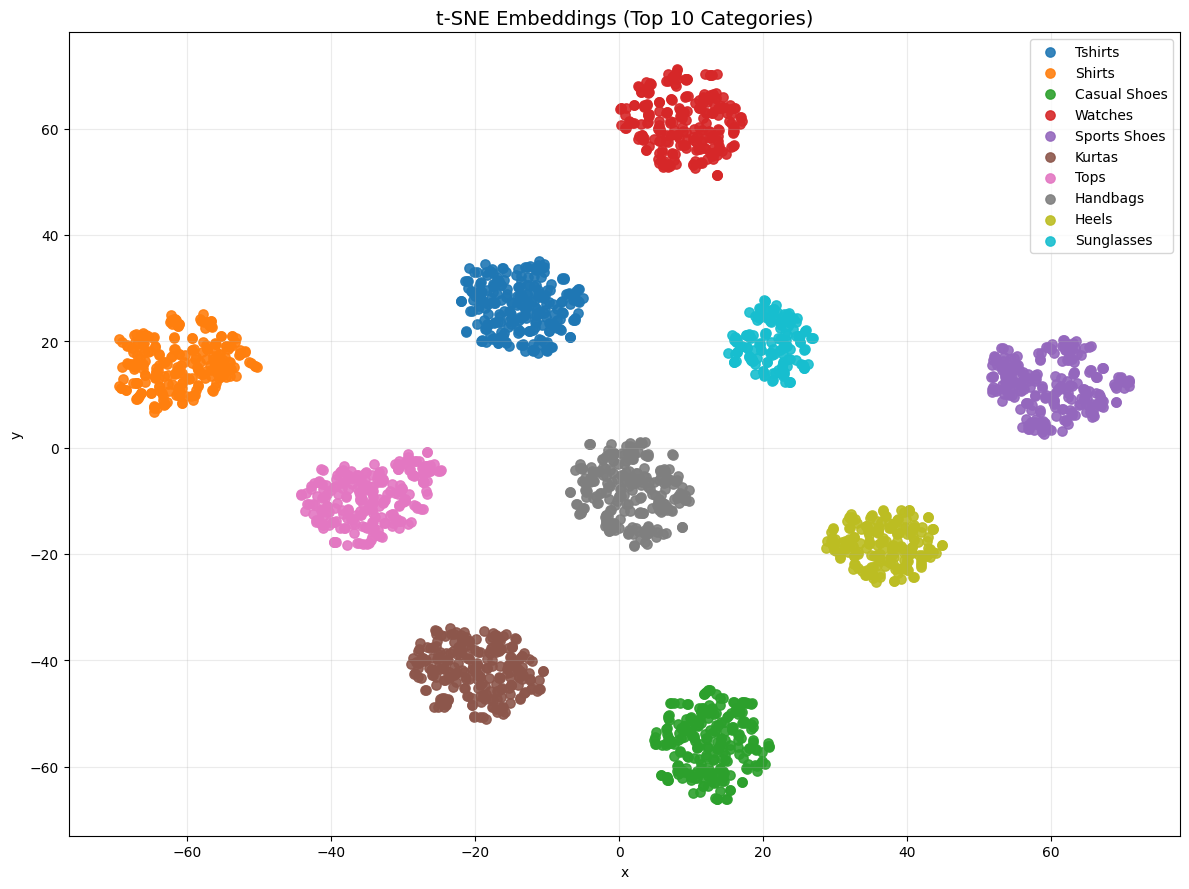

Saved: tsne_top10.png
Saved: tsne_top10_points.csv


In [16]:
# ---- t-SNE Top 10 categories ----
cats_series = pd.Series(test_cats)
top10 = cats_series.value_counts().head(config.tsne_top_k).index.tolist()

# lấy index theo top10
mask = np.isin(np.array(test_cats), top10)
embs_top = test_embs[mask]
cats_top = np.array(test_cats)[mask]

# sample đều mỗi category cho đẹp
rng = np.random.default_rng(config.seed)
selected = []
for c in top10:
    idx_c = np.where(cats_top == c)[0]
    take = min(config.tsne_points_per_cat, len(idx_c))
    chosen = rng.choice(idx_c, size=take, replace=False)
    selected.append(chosen)
selected = np.concatenate(selected)

embs_s = embs_top[selected]
cats_s = cats_top[selected]

print("t-SNE points:", embs_s.shape[0], "| dim:", embs_s.shape[1])
print("Top10:", top10)

tsne = TSNE(
    n_components=2,
    perplexity=config.tsne_perplexity,
    init="pca",
    learning_rate="auto",
    n_iter=config.tsne_iter,
    random_state=config.seed
)
Z = tsne.fit_transform(embs_s)

# Plot style giống bạn gửi: scatter + legend
plt.figure(figsize=(12, 9))
cmap = plt.get_cmap("tab10")

for i, c in enumerate(top10):
    m = (cats_s == c)
    plt.scatter(Z[m, 0], Z[m, 1], s=45, alpha=0.9, label=c, color=cmap(i))

plt.title("t-SNE Embeddings (Top 10 Categories)", fontsize=14)
plt.xlabel("x")
plt.ylabel("y")
plt.grid(alpha=0.25)
plt.legend(loc="upper right", frameon=True)
plt.tight_layout()
plt.savefig("tsne_top10.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved: tsne_top10.png")

# (Optional) lưu tọa độ để làm báo cáo/plot lại
tsne_df = pd.DataFrame({"x": Z[:,0], "y": Z[:,1], "category": cats_s})
tsne_df.to_csv("tsne_top10_points.csv", index=False)
print("Saved: tsne_top10_points.csv")
